# DEMONS
## Distribution Estimation with MOnte-Carlo for Noisy evolutions Strategies

In [1]:
import jax
import jax.numpy as jnp
import flax
import optax

import matplotlib.pyplot as plt
%matplotlib inline

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
from qdax.tasks.brax_envs import (
    make_policy_network_play_step_fn_brax,
    reset_based_scoring_function_brax_envs,
)
from qdax.core.rl_es_parts.canonical_es import CanonicalESConfig, CanonicalESEmitter, CanonicalESEmitterState

import jax
import jax.numpy as jnp
import functools

from qdax import environments
from qdax.types import Centroid, Descriptor, ExtraScores, Fitness, Genotype, RNGKey

from typing import Callable, Tuple


/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}

def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

optim_problem = "sphere"
# optim_problem = "rastrigin"
if optim_problem == "sphere":
    fitness_scoring = sphere_scoring
elif optim_problem == "rastrigin":
    fitness_scoring = rastrigin_scoring
else:
    raise Exception("Invalid opt function name given")

def scoring_function(x):
    scores, descriptors = fitness_scoring(x), (0, 0)
    return scores, descriptors, {}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

In [4]:
def make_noisy(scoring_function, noise_sigma):
    def noisy_scoring_fn(x, random_key):
        fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
        # Add noise to fitnesses
        random_key, noise_key = jax.random.split(random_key)
        noise = jax.random.normal(noise_key, fitnesses.shape) * noise_sigma
        fitnesses += noise
        return fitnesses, descriptors, extra_scores, random_key
    return noisy_scoring_fn

In [5]:
class Population(flax.struct.PyTreeNode):
    genotypes: Genotype
    evaluations: int
    sum_fitness: Fitness
    sum_squared_fitness: Fitness

    @property
    def mean_fitness(self):
        return self.sum_fitness / self.evaluations

    @property
    def std_fitness(self):
        return jnp.sqrt(self.sum_squared_fitness / self.evaluations - self.mean_fitness ** 2)

    @property
    def average_std(self):
        return self.std_fitness / jnp.sqrt(self.evaluations)

    def sample(self, rng_key):
        # Compute a normal distribution 
        # mean is mean_fitness
        # std if average_std
        # sample from this distribution
        return jax.random.normal(rng_key, shape=self.sum_fitness.shape) * self.average_std + self.mean_fitness
        
    @classmethod
    def init_default(cls, size, genotype):
        # default genotypes is all 0
        default_genotypes = jax.tree_util.tree_map(
            lambda x: jnp.zeros(shape=(size,) + x.shape, dtype=x.dtype),
            genotype,
        )
        return cls(
            genotypes=default_genotypes,
            evaluations=jnp.zeros(shape=(size,), dtype=jnp.int32),
            sum_fitness=jnp.zeros(shape=(size,), dtype=jnp.float32),
            sum_squared_fitness=jnp.zeros(shape=(size,), dtype=jnp.float32),
        )
    
    @classmethod
    def init(cls, genotypes):
        # default genotypes is all 0
        size = genotypes.shape[0]
        return cls(
            genotypes=genotypes,
            evaluations=jnp.zeros(shape=(size,), dtype=jnp.int32),
            sum_fitness=jnp.zeros(shape=(size,), dtype=jnp.float32),
            sum_squared_fitness=jnp.zeros(shape=(size,), dtype=jnp.float32),
        )
    
    def add_evaluation(self, index, fitness):
        return self.replace(
            evaluations=self.evaluations.at[index].add(1),
            sum_fitness=self.sum_fitness.at[index].add(fitness),
            sum_squared_fitness=self.sum_squared_fitness.at[index].add(fitness ** 2),
        )
    
    def add_batch_evaluation(self, index, fitnesses):
        # Add multiple evals for a single index
        return self.replace(
            evaluations=self.evaluations.at[index].add(fitnesses.shape[0]),
            sum_fitness=self.sum_fitness.at[index].add(jnp.sum(fitnesses, axis=0)),
            sum_squared_fitness=self.sum_squared_fitness.at[index].add(jnp.sum(fitnesses ** 2, axis=0)),
        )

In [6]:
from qdax.core.emitters.emitter import Emitter, EmitterState
from flax.struct import dataclass as fdataclass

class ESState(EmitterState):
    offspring: Genotype
    generation_count: int
    random_key: RNGKey

class ES:
    def __init__(
            self, 
            config: CanonicalESConfig,
            rollout_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            eval_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            ):
        self.config = config
        self._eval_fn = eval_fn
        self._rollout_fn = rollout_fn

    def init(
        self, 
        init_genotype: Genotype, 
        random_key: RNGKey
    ) -> Tuple[ESState, RNGKey]:
        return (
            ESState(
                offspring=init_genotype,
                generation_count=0,
                random_key=random_key,
            ),
            random_key,
        )

    def sample(self, parent, random_key):
        random_key, subkey = jax.random.split(random_key)

        sample_number = self.config.sample_number
        # print("sample_number", sample_number)
        # Make it so the first dimension of parent is 1
        parent = jax.tree_map(
            lambda x: x[None, ...],
            parent,
        )
        
        # Sample noise
        sample_noise = jax.tree_map(
            lambda x: jax.random.normal(
                key=subkey,
                shape=jnp.repeat(x, sample_number, axis=0).shape,
            ),
            parent,
        )
        # print("sample_noise", sample_noise.shape)
        # Add noise to parent
        networks = jax.tree_map(
            lambda x: jnp.repeat(x, sample_number, axis=0),
            parent,
        )
        # print("networks", networks.shape)
        networks = jax.tree_map(
            lambda mean, noise: mean + self.config.sample_sigma * noise,
            networks,
            sample_noise,
        )
        # print("networks", networks.shape)

        return networks, random_key

    def update(
            self, 
            emitter_state: ESState,
            population: Population,
            scores: Fitness,
            parent: Genotype,
    ):
        sample_number = self.config.sample_number 
        
        # (pop - parent) / sigma
        sample_noise = jax.tree_map(
            lambda x: (x - parent) / self.config.sample_sigma,
            population.genotypes,
        )

        # Compute rank and weight
        ranking_indices = jnp.argsort(scores, axis=0)
        ranks = jnp.argsort(ranking_indices, axis=0)
        ranks = self.config.sample_number - ranks  # Inverting the ranks

        mu = self.config.canonical_mu  # Number of parents

        weights = jnp.where(ranks <= mu, jnp.log(mu + 0.5) - jnp.log(ranks), 0)
        weights /= jnp.sum(weights)  # Normalizing the weights

        # print("weights", weights.shape)

        # Reshaping rank to match shape of genotype_noise
        weights = jax.tree_map(
            lambda x: jnp.reshape(
                jnp.repeat(weights.ravel(), x[0].ravel().shape[0], axis=0), x.shape
            ),
            sample_noise,
        )

        # Computing the update
        # Noise is multiplied by rank-based weight
        gradient = jax.tree_map(
            lambda noise, w: jnp.multiply(noise, w),
            sample_noise,
            weights,
        )
        # Noise is summed over the sample dimension and multiplied by sigma
        gradient = jax.tree_map(
            lambda x: jnp.reshape(x, (sample_number, -1)),
            gradient,
        )
        gradient = jax.tree_map(
            lambda g, p: jnp.reshape(
                jnp.sum(g, axis=0) * self.config.sample_sigma,
                p.shape,
            ),
            gradient,
            parent,
        )

        offspring = optax.apply_updates(parent, gradient)
        return offspring, emitter_state


    def step(self, emitter_state: ESState, n_gens=100):
        emitter_state, metrics = jax.lax.scan(
            self.scan_step,
            emitter_state,
            None, 
            length=n_gens,
        )
        metrics = jax.tree_map(lambda x: x.squeeze(), metrics)

        return emitter_state, metrics
        
    def scan_step(self, carry, unused):
        emitter_state = carry

        # Sample population
        genotypes, random_key = self.sample(emitter_state.offspring, emitter_state.random_key)
        population = Population.init(genotypes=genotypes)
        # Evaluate population
        scores, descriptors, extra_scores, random_key = self._rollout_fn(population.genotypes, random_key)
        # Update population
        offspring, emitter_state = self.update(
            emitter_state,
            population,
            scores,
            emitter_state.offspring,
        )

        # Evaluate population
        indices = jnp.arange(self.config.sample_number)
        genomes = population.genotypes[indices]
        random_key, key = jax.random.split(random_key)
        f, d, _, _ = self._rollout_fn(genomes, key)

        population = population.add_evaluation(indices, f)

        # Update population
        scores = population.mean_fitness
        offspring, new_emitter_state = self.update(
            emitter_state = emitter_state,
            population = population,
            scores = scores,
            parent = emitter_state.offspring,
        )

        # Add 1 dim to offspring
        offspring = jnp.expand_dims(offspring, axis=0)

        # Eval true fitness of offspring
        offspring_fitnesses, offspring_descriptors, extra_scores, random_key = self._eval_fn(offspring, jax.random.PRNGKey(0))

        metrics = {
            "offspring_fitness": offspring_fitnesses,
            "offspring_descriptors": offspring_descriptors,
            "mmean_pop_fitness": f.mean(),
            "center_genome": offspring[0],
        }

        new_emitter_state = ESState(
            offspring=offspring[0],
            generation_count=emitter_state.generation_count + 1,
            random_key=random_key,
        )

        return new_emitter_state, metrics

In [7]:
# Initialize population
pop_size = 100
n_genes = 10
# noise_sigma = 0.1

config = CanonicalESConfig(
        sample_sigma=0.01,
        sample_number=pop_size,
        canonical_mu=int(pop_size/2),
    )

n_loops = 1000

In [20]:
print("Normal ES")
for noise_sigma in [0, 0.001, 0.01, 0.1, 1]:
    noisy_scoring_fn = make_noisy(scoring_function, noise_sigma=noise_sigma)

    es = ES(
        config=config,
        rollout_fn=noisy_scoring_fn,
        eval_fn=scoring_fn,
    )

    parent = jnp.ones(n_genes)

    es_state, random_key = es.init(
        init_genotype=parent,
        random_key=jax.random.PRNGKey(0),
    )

    new_emitter_state, metrics = es.step(es_state, n_gens=n_loops)
    fit = metrics["offspring_fitness"]
    max_fit = fit.max()
    print(f"Noise {noise_sigma} | Max fitness: {max_fit:.2f}")
    # %matplotlib inline
    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(fit)
    # ax.set_xlabel("Generation")
    # ax.set_ylabel("Fitness")
    # plt.title(f"Fitness over {n_loops} generations with noise sigma {noise_sigma}\n Max fitness: {max_fit:.2f}")
    # plt.show()


Normal ES
Noise 0 | Max fitness: -0.00
Noise 0.001 | Max fitness: -0.00
Noise 0.01 | Max fitness: -0.03
Noise 0.1 | Max fitness: -0.77
Noise 1 | Max fitness: -5.13


In [21]:
class StaticResamplingES(ES):
    def __init__(
            self, 
            config: CanonicalESConfig,
            rollout_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            eval_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            gen_budget: int=1,
            ):
        
        super().__init__(
            config=config,
            rollout_fn=rollout_fn,
            eval_fn=eval_fn,
        )
        self.gen_budget = gen_budget # budget for each offspring


    def scan_step(self, carry, unused):
        emitter_state = carry

        # Sample population
        genotypes, random_key = self.sample(emitter_state.offspring, emitter_state.random_key)
        population = Population.init(genotypes=genotypes)
        # Evaluate population
        scores, descriptors, extra_scores, random_key = self._rollout_fn(population.genotypes, random_key)
        # Update population
        offspring, emitter_state = self.update(
            emitter_state,
            population,
            scores,
            emitter_state.offspring,
        )

        # Evaluate population
        indices = jnp.arange(self.config.sample_number)
        genomes = population.genotypes[indices]

        if self.gen_budget == 1:
            # split key
            random_key, key = jax.random.split(random_key)
            f, d, _, _ = self._rollout_fn(genomes, key)
            population = population.add_evaluation(indices, f)
            pop_fit = f.mean()
        else:
            # get gen_budget keys
            random_key, key = jax.random.split(random_key)
            keys = jax.random.split(key, self.gen_budget)
            # eval
            multi_eval, d, _, _ = jax.vmap(
                lambda seed: noisy_scoring_fn(genomes, seed),
                in_axes=(0),
            )(
                keys
            )
            pop_fit = multi_eval.mean()
            population = population.add_batch_evaluation(indices, multi_eval)

        # Update population
        scores = population.mean_fitness
        offspring, new_emitter_state = self.update(
            emitter_state = emitter_state,
            population = population,
            scores = scores,
            parent = emitter_state.offspring,
        )

        # Add 1 dim to offspring
        offspring = jnp.expand_dims(offspring, axis=0)

        # Eval true fitness of offspring
        offspring_fitnesses, offspring_descriptors, extra_scores, random_key = self._eval_fn(offspring, jax.random.PRNGKey(0))

        metrics = {
            "offspring_fitness": offspring_fitnesses,
            "offspring_descriptors": offspring_descriptors,
            "mmean_pop_fitness": pop_fit,
            "center_genome": offspring[0],
        }

        new_emitter_state = ESState(
            offspring=offspring[0],
            generation_count=emitter_state.generation_count + 1,
            random_key=random_key,
        )

        return new_emitter_state, metrics

In [27]:
eval_budget = 5

print(f"Static Resampling ES - Budget {eval_budget}")
for noise_sigma in [0, 0.001, 0.01, 0.1, 1]:
    noisy_scoring_fn = make_noisy(scoring_function, noise_sigma=noise_sigma)

    es = StaticResamplingES(
        config=config,
        rollout_fn=noisy_scoring_fn,
        eval_fn=scoring_fn,
        gen_budget=eval_budget,
    )

    parent = jnp.ones(n_genes)

    es_state, random_key = es.init(
        init_genotype=parent,
        random_key=jax.random.PRNGKey(0),
    )

    new_emitter_state, metrics = es.step(es_state, n_gens=n_loops)
    fit = metrics["offspring_fitness"]
    max_fit = fit.max()
    print(f"Noise {noise_sigma} | Max fitness: {max_fit:.2f}")

    # %matplotlib inline
    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(fit)
    # ax.set_xlabel("Generation")
    # ax.set_ylabel("Fitness")
    # plt.title(f"Fitness with noise sigma {noise_sigma} and {eval_budget} evals\n Max fitness: {max_fit:.2f}")
    # plt.show()


Static Resampling ES - Budget 5
Noise 0 | Max fitness: -0.00
Noise 0.001 | Max fitness: -0.00
Noise 0.01 | Max fitness: -0.01
Noise 0.1 | Max fitness: -1.03
Noise 1 | Max fitness: -8.84


In [23]:
class SmartResamplingES(ES):
    def __init__(
            self, 
            config: CanonicalESConfig,
            rollout_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            eval_fn: Callable[
                [Genotype, RNGKey], Tuple[Fitness, Descriptor, ExtraScores, RNGKey]
            ],
            gen_budget: int=1,
            eval_batches:int = 1,
            ):
        
        super().__init__(
            config=config,
            rollout_fn=rollout_fn,
            eval_fn=eval_fn,
        )
        self.gen_budget = gen_budget # budget for each offspring
        self.eval_batches = eval_batches

    def select_indices(self, population, n=1):
        raise NotImplementedError


    def scan_step(self, carry, unused):
        emitter_state = carry

        # Sample population
        genotypes, random_key = self.sample(emitter_state.offspring, emitter_state.random_key)
        population = Population.init(genotypes=genotypes)
        # Evaluate population
        scores, descriptors, extra_scores, random_key = self._rollout_fn(population.genotypes, random_key)
        # Update population
        offspring, emitter_state = self.update(
            emitter_state,
            population,
            scores,
            emitter_state.offspring,
        )

        # Evaluate population
        indices = jnp.arange(self.config.sample_number)
        genomes = population.genotypes[indices]

        if self.gen_budget == 1:
            # split key
            random_key, key = jax.random.split(random_key)
            f, d, _, _ = self._rollout_fn(genomes, key)
            population = population.add_evaluation(indices, f)
            pop_fit = f.mean()
        else:
            # First 2 evals
            random_key, key = jax.random.split(random_key)
            keys = jax.random.split(key, 2)
            # eval
            multi_eval, d, _, _ = jax.vmap(
                lambda seed: noisy_scoring_fn(genomes, seed),
                in_axes=(0),
            )(
                keys
            )
            population = population.add_batch_evaluation(indices, multi_eval)

            remaining_evals = (self.gen_budget - 2) * self.config.sample_number
            if remaining_evals > 0:
                while remaining_evals > 0:
                    indices = self.select_indices(population, n=self.eval_batches)
                    genomes = population.genotypes[indices]
                    random_key, key = jax.random.split(random_key)
                    f, d, _, _ = self._rollout_fn(genomes, key)
                    population = population.add_evaluation(indices, f)
                    remaining_evals -= self.eval_batches

            pop_fit = population.mean_fitness.mean()

        # Update population
        scores = population.mean_fitness
        offspring, new_emitter_state = self.update(
            emitter_state = emitter_state,
            population = population,
            scores = scores,
            parent = emitter_state.offspring,
        )

        # Add 1 dim to offspring
        offspring = jnp.expand_dims(offspring, axis=0)

        # Eval true fitness of offspring
        offspring_fitnesses, offspring_descriptors, extra_scores, random_key = self._eval_fn(offspring, jax.random.PRNGKey(0))

        metrics = {
            "offspring_fitness": offspring_fitnesses,
            "offspring_descriptors": offspring_descriptors,
            "mmean_pop_fitness": pop_fit,
            "center_genome": offspring[0],
        }

        new_emitter_state = ESState(
            offspring=offspring[0],
            generation_count=emitter_state.generation_count + 1,
            random_key=random_key,
        )

        return new_emitter_state, metrics

In [24]:
class DynamicResamplingES(SmartResamplingES):
    def select_indices(self, population, n=1):
        average_std = population.average_std
        # sort by highest first
        sorted_indices = jnp.argsort(average_std)[::-1]
        # select top n
        selected_indices = sorted_indices[:n]
        return selected_indices

In [25]:
eval_budget = 5
eval_batch = 10

print(f"Dynamic resampling \nEval budget: {eval_budget} | Eval batch: {eval_batch}")
for noise_sigma in [0, 0.001, 0.01, 0.1, 1]:
    noisy_scoring_fn = make_noisy(scoring_function, noise_sigma=noise_sigma)

    es = DynamicResamplingES(
        config=config,
        rollout_fn=noisy_scoring_fn,
        eval_fn=scoring_fn,
        gen_budget=eval_budget,
        eval_batches=eval_batch,
    )

    parent = jnp.ones(n_genes)

    es_state, random_key = es.init(
        init_genotype=parent,
        random_key=jax.random.PRNGKey(0),
    )

    new_emitter_state, metrics = es.step(es_state, n_gens=n_loops)
    fit = metrics["offspring_fitness"]
    max_fit = fit.max()
    print(f"Noise {noise_sigma} | Max fitness: {max_fit:.2f}")

    # %matplotlib inline
    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(fit)
    # ax.set_xlabel("Generation")
    # ax.set_ylabel("Fitness")
    # plt.title(f"Fitness with noise sigma {noise_sigma} and {eval_budget} evals\n Max fitness: {max_fit:.2f}")
    # plt.show()


Dynamic resampling 
Eval budget: 5 | Eval batch: 10
Noise 0 | Max fitness: -0.00
Noise 0.001 | Max fitness: -0.00
Noise 0.01 | Max fitness: -0.01
Noise 0.1 | Max fitness: -0.96
Noise 1 | Max fitness: -9.49


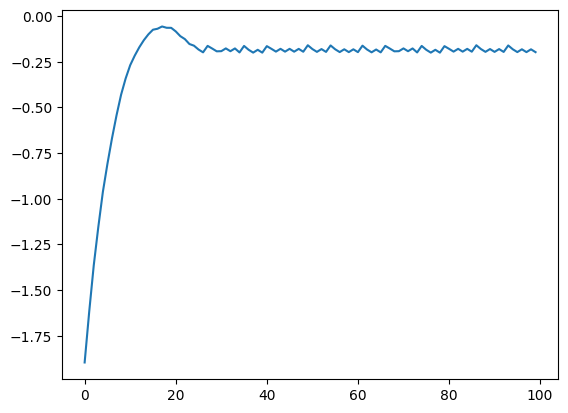

In [216]:
import matplotlib.pyplot as plt
plt.plot(center_fit)

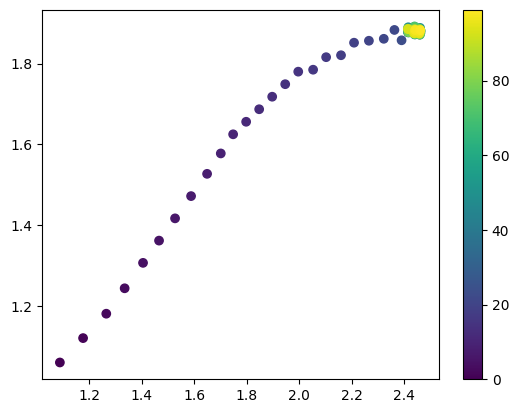

In [217]:
# scatter plot
plt.figure()
steps = jnp.arange(n_loops)
plt.scatter(jnp.array(centers)[:,0], jnp.array(centers)[:,1], c=steps, cmap='viridis')
plt.colorbar()
plt.show()

In [155]:
pop.evaluations

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [157]:
pop = pop.add_batch_evaluation(indices, f)

# Update population
scores = pop.mean_fitness
offspring, new_emitter_state = es.update(
    emitter_state = es_state,
    population = pop,
    scores = scores,
    parent = parent,
)

weights (10,)


In [158]:
offspring

Array([ 7.9769790e-02, -5.2778982e-05, -4.5356005e-02,  8.6363174e-02,
       -3.4983918e-02], dtype=float32)

In [126]:
pop.genotypes

Array([[ 0.18546747,  0.08980529, -0.05096747, -0.01913436, -0.05588307],
       [ 0.14093108, -0.14872812,  0.07834691,  0.07007926,  0.00179523],
       [-0.25857216, -0.05018541,  0.08676722,  0.04120107, -0.0359513 ],
       [ 0.12125856, -0.05274253, -0.06951106,  0.00791412, -0.03536552],
       [-0.02252335, -0.02596724, -0.10178605, -0.01946759, -0.11107538],
       [-0.06741806, -0.31712547, -0.0835046 ,  0.18132459, -0.08914001],
       [ 0.09041903, -0.05459335,  0.0742484 , -0.05055738, -0.12403842],
       [-0.07762434,  0.01526044,  0.18720882,  0.09146019, -0.02538448],
       [-0.06570152,  0.04072116,  0.0344565 ,  0.16349545, -0.10023405],
       [ 0.22829516, -0.00177734, -0.1956168 ,  0.05904857,  0.01998603]],      dtype=float32)

In [123]:

genotypes.shape

sample_number 10
sample_noise (10, 100)
networks (10, 100)
networks (10, 100)


(10, 100)

In [124]:
es.update(es_state, pop)

TypeError: update() missing 2 required positional arguments: 'scores' and 'parent'

In [61]:
genome = jnp.zeros(num_dimensions)
# reproduce 10 times
genomes = jnp.repeat(genome[None, :], 1000, axis=0)
genomes.shape

(1000, 100)

In [62]:
f, d, _, _ = scoring_fn(genomes, jax.random.PRNGKey(0))
f.mean(), f.std()

(Array(-419.43048, dtype=float32), Array(6.1035156e-05, dtype=float32))

In [63]:
noisy_scoring_fn = make_noisy(scoring_function, noise_sigma=10)
f, d, _, _ = noisy_scoring_fn(genomes, jax.random.PRNGKey(0))
f.mean(), f.std()

(Array(-418.81766, dtype=float32), Array(10.113372, dtype=float32))

In [64]:
pop_size = 10
n_genes = 100
noise_sigma = 100

noisy_scoring_fn = make_noisy(scoring_function, noise_sigma=noise_sigma)


genotype = jnp.ones(n_genes)
pop = Population.init_default(pop_size, genotype)

In [65]:
indices = [1, 5, 9]
indices = jnp.array(indices)

indices = jnp.arange(pop_size)

# Get genomes
genomes = pop.genotypes[indices]
genomes.shape

(10, 100)

In [66]:
f, d, _, _ = noisy_scoring_fn(genomes, jax.random.PRNGKey(0))
f

Array([-458.24304, -423.91757, -623.703  , -411.4981 , -386.0805 ,
       -339.83066, -563.5502 , -588.7302 , -456.79962, -573.44183],      dtype=float32)

In [67]:
pop = pop.add_evaluation(indices, f)
pop.mean_fitness

Array([-458.24304, -423.91757, -623.703  , -411.4981 , -386.0805 ,
       -339.83066, -563.5502 , -588.7302 , -456.79962, -573.44183],      dtype=float32)

In [68]:
key = jax.random.PRNGKey(0)
n_keys = 5
keys = jax.random.split(key, n_keys)

multi_eval = jax.vmap(
    lambda seed: noisy_scoring_fn(genomes, seed),
    in_axes=(0),
)(
    keys
)

In [69]:
multi_eval[0]

Array([[-415.21292, -370.8639 , -387.21613, -488.34027, -321.62238,
        -347.68195, -332.86102, -449.73804, -437.2649 , -624.2903 ],
       [-482.19757, -241.51247, -390.74802, -416.24878, -586.7875 ,
        -439.37436, -243.76979, -526.5892 , -380.16022, -311.34586],
       [-540.3326 , -481.07352, -440.29495, -642.423  , -344.13007,
        -576.8252 , -425.48   , -614.4184 , -333.1338 , -497.5859 ],
       [-278.40436, -291.87744, -377.46762, -220.04112, -217.50337,
        -342.4496 , -332.22675, -199.67677, -537.60004, -363.89874],
       [-280.65036, -370.188  , -421.4763 , -335.7251 , -512.48145,
        -353.58386, -490.0584 , -336.02908, -426.41205, -531.24194]],      dtype=float32)

In [70]:
new_pop = pop.add_batch_evaluation(indices, multi_eval[0])

In [71]:
new_pop.mean_fitness

Array([-409.17352, -363.23883, -440.151  , -419.04608, -394.76755,
       -399.9576 , -397.99106, -452.53027, -428.56177, -483.63412],      dtype=float32)

TypeError: __init__() got an unexpected keyword argument 'scoring_fn'